In [11]:
# Import necessary dependencies
import os
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram

In [2]:
# Define path
file_path = os.path.join('..', 'geometry', 'geometry_offset.csv')
das_path = os.path.join('..', 'preprocessed_data', '20210901', '20210901_000000.npz')

#### DAS Geometry

In [3]:
# Read CSV data
das_fiber_all = pd.read_csv(file_path)
das_fiber_all = das_fiber_all.drop(das_fiber_all.columns[0], axis=1)
das_fiber_all

,ch,long,lat
0,399,-122.181048,37.435539
1,400,-122.181101,37.435501
2,401,-122.181166,37.435452
3,402,-122.181247,37.435391
4,403,-122.181307,37.435347
...,...,...,...
346,745,-122.205771,37.421297
347,746,-122.205873,37.421284
348,747,-122.205963,37.421272
349,748,-122.206011,37.421266


In [4]:
# Compute center of map
center_lat = das_fiber_all['lat'].mean()
center_lon = das_fiber_all['long'].mean()

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=15, tiles='OpenStreetMap')

# Add channel markers
for _, row in das_fiber_all.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=f"Ch: {row['ch']}"
    ).add_to(m)


# Connect channels with a red line (fiber path)
folium.PolyLine(
    das_fiber_all[['lat', 'long']].values.tolist(),
    color='red',
    weight=2,
    opacity=0.8
).add_to(m)

# Add layer control (optional)
folium.LayerControl().add_to(m)

# Display map
m

#### DAS Visualization

In [ ]:
# Load das data
data = np.load(das_path)

# Inspect variables inside 
for key in data:
    print(f'{key}')

data
dt
t_axis
x_axis
event_files
event_time
pre_time
post_time


In [8]:
# DAS interrogator parameters
dt = 0.004 # Sampling rate in sec (or 250 Hz)
gauge_len = 16.0
chann_len = 8.16

In [20]:
# Extract das data (channels, time)
das_array = data['data']
dt = data['dt']                 # Sampling rate in sec
N = data['data'].shape[1]       # Number of samples
T = N * dt                      # Total duration

print('DAS array shape:', das_array.shape)
print('Time axis shape:', data['t_axis'].shape)
print('Channel positions:', data['x_axis'].shape)
print(f'Sampling rates: {dt} s')
print(f'Total duration: {T/60:.2f} minutes')

DAS array shape: (350, 157500)
Time axis shape: (157500,)
Channel positions: (350,)
Sampling rates: 0.004 s
Total duration: 10.50 minutes


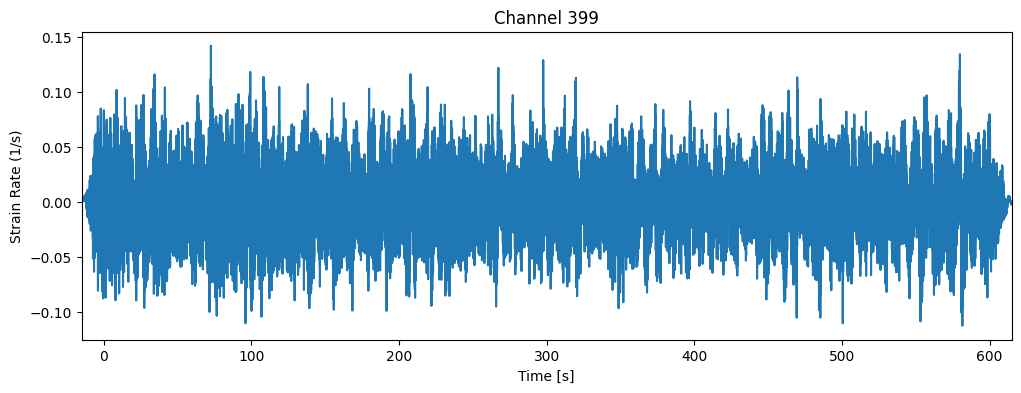

In [47]:
# Plot single channel
ch_idx = 0
plt.figure(figsize=(12, 4))
plt.plot(data['t_axis'], data['data'][ch_idx])
plt.xlabel('Time [s]')
plt.ylabel('Strain Rate (1/s)')
plt.title(f'Channel {data['x_axis'][ch_idx]}')
plt.xlim(data['t_axis'].min(), data['t_axis'].max())
plt.show()

/var/folders/pf/3_nyp_6j7059y5qxp6tr1_vm0000gn/T/ipykernel_92709/4043715928.py:18: RuntimeWarning: divide by zero encountered in log10
  im = axes[1].pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='auto', cmap='viridis')


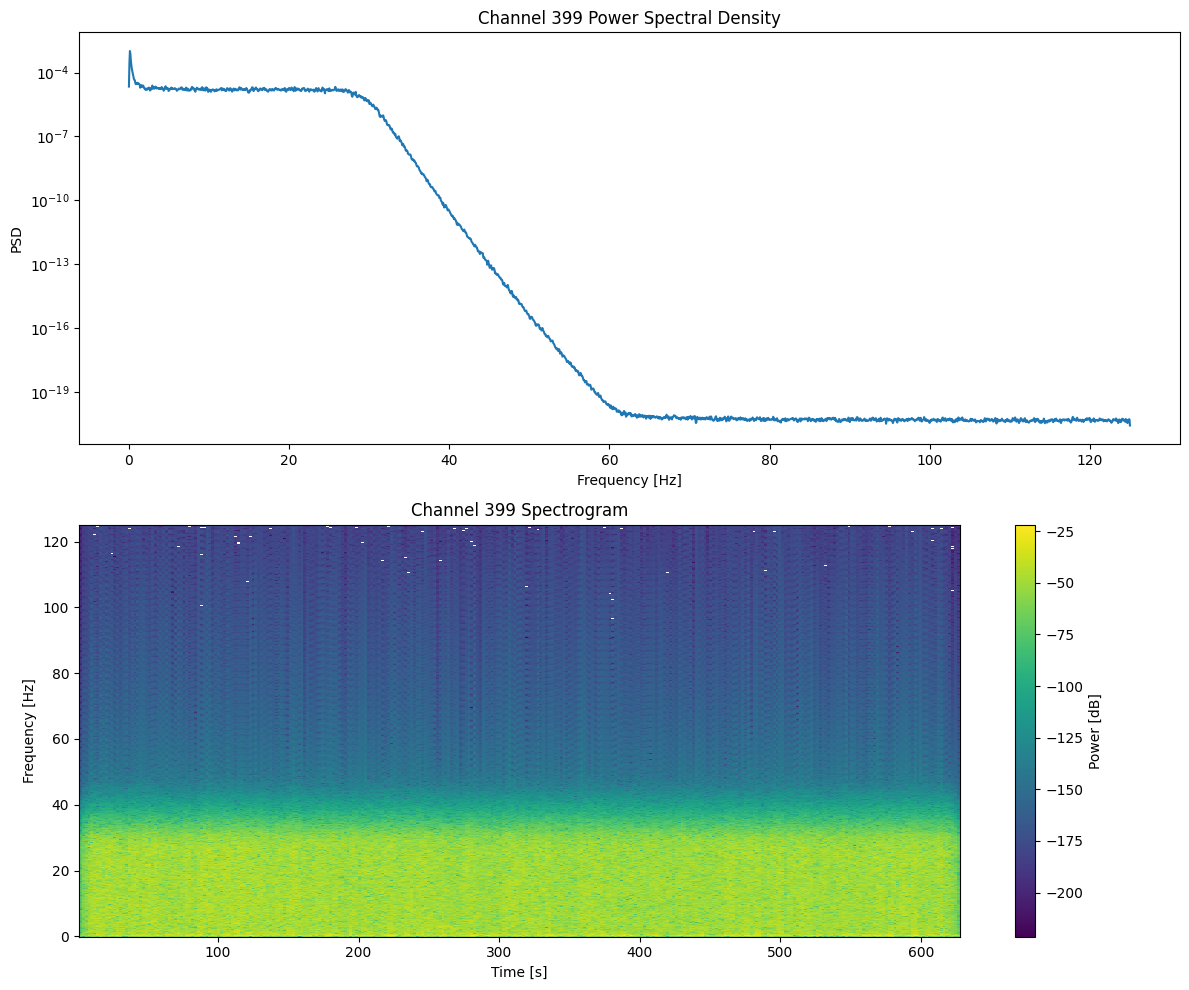

In [53]:
# Plot single PSD and spectrogram
signal = data['data'][ch_idx]
t = data['t_axis']
dt = data['dt']
fs = 1 / dt  # Sampling frequency

# Compute PSD using Welch method
f, Pxx = welch(signal, fs=fs, nperseg=4096)
f_spec, t_spec, Sxx = spectrogram(signal, fs=fs, nperseg=1024, noverlap=512)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
# PSD
axes[0].semilogy(f, Pxx)
axes[0].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('PSD')
axes[0].set_title(f'Channel {data['x_axis'][ch_idx]} Power Spectral Density')
# Spectrogram
im = axes[1].pcolormesh(t_spec, f_spec, 10 * np.log10(Sxx), shading='auto', cmap='viridis')
axes[1].set_ylabel('Frequency [Hz]')
axes[1].set_xlabel('Time [s]')
axes[1].set_title(f'Channel {data['x_axis'][ch_idx]} Spectrogram')
fig.colorbar(im, ax=axes[1], label='Power [dB]')

plt.tight_layout()
plt.show()

In [ ]:
# Compute clipping value to avoid extreme outliers in the colormap
pclip = 99
clip = np.percentile(data['data'], pclip)

np.float32(0.07805067)

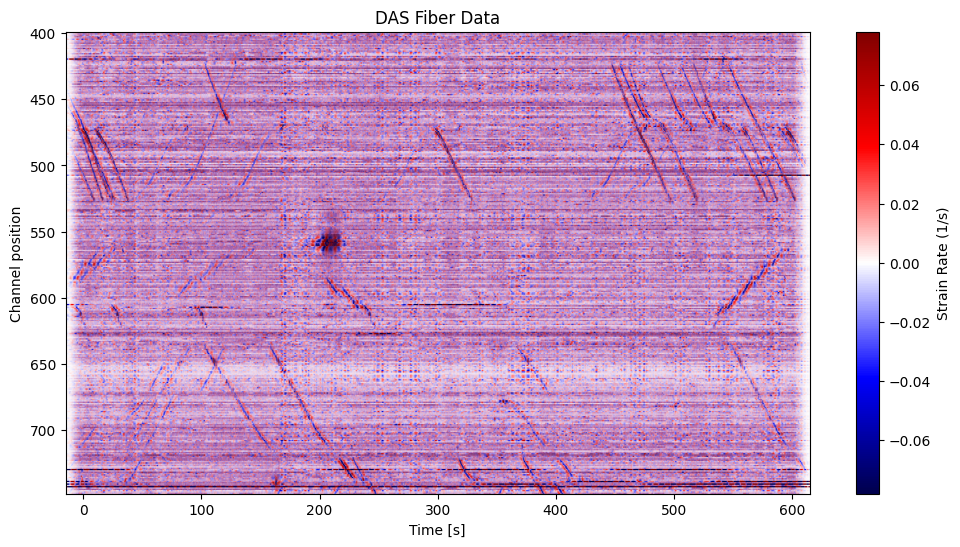

In [51]:
# Plot all channels as a heatmap
plt.figure(figsize=(12, 6))
plt.imshow(data['data'], aspect='auto',
           extent=[data['t_axis'][0], data['t_axis'][-1],
                   data['x_axis'][-1], data['x_axis'][0]],
                   vmin=-clip, vmax=clip,
           cmap='seismic')
plt.colorbar(label='Strain Rate (1/s)')
plt.xlabel('Time [s]')
plt.ylabel('Channel position')
plt.title('DAS Fiber Data')
plt.show()